In [1]:
from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings, AmazonKnowledgeBasesRetriever
import boto3

session = boto3.Session(profile_name="default")
bedrock_client = session.client('bedrock-runtime')

model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
model_kwargs =  { 
        "max_tokens": 512,
        "temperature": 0,
        "top_p": 1,
}

# LangChain class for chat
model = ChatBedrock(
    client=bedrock_client,
    model_id=model_id,
    model_kwargs=model_kwargs,
)


# Setup tools for custom Agent

In [2]:
import pandas as pd

#Load the laptop product orders CSV into a Pandas dataframe.
product_orders_df = pd.read_csv("data/Laptop Orders.csv")
print(product_orders_df)

   Order ID Product Ordered  Quantity Ordered Delivery Date
0  ORD-8276   SpectraBook S                 3    2024-10-16
1  ORD-6948    OmegaPro G17                 3    2024-10-25
2  ORD-7311   NanoEdge Flex                 2    2024-10-19
3  ORD-4633    OmegaPro G17                 2    2024-10-15
4  ORD-2050      GammaAir X                 2    2024-10-26


In [3]:
from langchain_core.tools import tool

@tool
def get_order_details(order_id:str) -> str :
    """
    This function returns details about a laptop order, given an order ID
    It performs an exact match between the input order id and available order ids
    If a match is found, it returns products (laptops) ordered, quantity ordered and delivery date.
    If there is NO match found, it returns -1
    """
    #Filter Dataframe for order ID
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    #Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return -1
    else:
        return match_order_df.iloc[0].to_dict()

#Test the tool. Before running the test, comment the @tool annotation
#print(get_order_details("ORD-6948"))
#print(get_order_details("ORD-9999"))

@tool
def update_quantity(order_id:str, new_quantity:int) -> bool :
    """
    This function updates the quantity of products ( laptops ) ordered for a given order Id.
    It there are no matching orders, it returns False.
    """
    #Find if matching record exists
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    #Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return -1
    else:
        product_orders_df.loc[
            product_orders_df["Order ID"] == order_id, 
                "Quantity Ordered"] = new_quantity
        return True
        
#Test the tool. Before running the test, comment the @tool annotation
#print(get_order_details("ORD-6948"))
#print(update_quantity("ORD-6948", 1))
#print(get_order_details("ORD-6948"))
#print(update_quantity("ORD-9999",2))
#print(product_orders_df)

# Setup the Custom Orders Agent

In [4]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from IPython.display import Image
import json

#An Agent State class that keep state of the agent while it answers a query
class OrdersAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#-----------------------------------------------------------------------------
#An agent class that manages all agentic interactions
class OrdersAgent:

    #Setup the agent graph, tools and memory
    def __init__(self, model, tools, system_prompt, debug):
        
        self.system_prompt=system_prompt
        self.debug=debug

        #Setup the graph for the agent manually
        agent_graph=StateGraph(OrdersAgentState)
        agent_graph.add_node("orders_llm",self.call_llm)
        agent_graph.add_node("orders_tools",self.call_tools)
        agent_graph.add_conditional_edges(
            "orders_llm",
            self.is_tool_call,
            {True: "orders_tools", False: END }
        )
        agent_graph.add_edge("orders_tools","orders_llm")
        #Set where there graph starts
        agent_graph.set_entry_point("orders_llm")

        #Add chat memory
        self.memory=MemorySaver()
        #compile the graph
        self.agent_graph = agent_graph.compile(checkpointer=self.memory)

        #Setup tools
        self.tools = { tool.name : tool for tool in tools }
        if self.debug:
            print("\nTools loaded :", self.tools)
            
        #attach tools to model
        self.model=model.bind_tools(tools)


    #Call the LLM with the messages to get next action/result
    def call_llm(self, state:OrdersAgentState):
        
        messages=state["messages"]

        #If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages
            
        #invoke the model with the message history
        result = self.model.invoke(messages)
        if self.debug:
            print(f"\nLLM Returned : {result}")
        #Return the LLM output
        return { "messages":[result] }
    
    
    #Check if the next action is a tool call.
    def is_tool_call(self, state:OrdersAgentState):
        last_message = state["messages"][-1]
        #print("Last result from LLM : ", last_message)
        #If tool action is requested
        if len(last_message.tool_calls) > 0 :
            return True
        else:
            return False

    #Execute the tool requested with the given parameters
    def call_tools(self, state:OrdersAgentState):
        #Get last message
        tool_calls = state["messages"][-1].tool_calls
        results=[]

        #Multiple tool calls may be requested. Execute one by one
        for tool in tool_calls:
            #Handle tool missing error
            if not tool["name"] in self.tools:
                print(f"Unknown tool name {tool}")
                result = "Invalid tool found. Please retry"
            else:
                #Call the tool and collect results
                result=self.tools[tool["name"]].invoke(tool["args"])

            #append results to the list of tool results
            results.append(ToolMessage(tool_call_id=tool['id'], 
                                       name=tool['name'], 
                                       content=str(result)))

            if self.debug:
                print(f"\nTools returned {results}")
            #return tool results
            return { "messages" : results }

In [10]:
#Setup the custom agent

#Note that this is a string, since the model init only accepts a string.
system_prompt = """
    You are professional chatbot that manages orders for laptops sold by our company.
    The tools allow for retrieving order details as well as update order quantity.
    Do NOT reveal information about other orders than the one requested.
    You will handle small talk and greetings by producing professional responses.
    """

#Create the custom orders agent
orders_agent = OrdersAgent(model, 
                           [get_order_details, update_quantity], 
                           system_prompt,
                           debug=False)

#Visualize the Agent
# Image(orders_agent.agent_graph.get_graph().draw_mermaid_png())

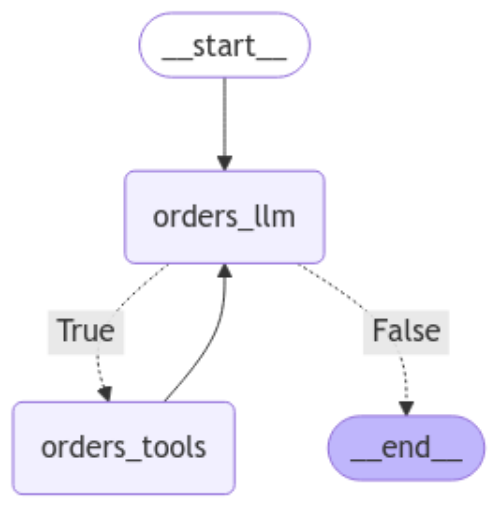

 # Setup and execute the Orders Chatbot

In [11]:
import uuid
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-7311",
    "Can you add one more of that laptop to the order? ",
    "Can you show me the details again ? ",
    "What about order ORD-9999 ?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = orders_agent.agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : How are you doing?

AGENT : Hello! As an AI assistant, I don't have personal feelings, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?
----------------------------------------
USER : Please show me the details of the order ORD-7311

AGENT : Great, I was able to retrieve the details for order ORD-7311:

- Order ID: ORD-7311
- Product Ordered: NanoEdge Flex
- Quantity Ordered: 4
- Delivery Date: 2024-10-19

Please let me know if you need anything else regarding this order.
----------------------------------------
USER : Can you add one more of that laptop to the order? 

AGENT : Great, I've updated the quantity for order ORD-7311 to 5 NanoEdge Flex laptops. The order details are now:

- Order ID: ORD-7311 
- Product Ordered: NanoEdge Flex
- Quantity Ordered: 5
- Delivery Date: 2024-10-19

Please let me know if you need anything else!
-----------------------------------

# How Tool Calling in the Agent - ChatGPT

✅ How Tool Calling Works in This Agent
🔁 Graph Flow:
Start at orders_llm

After each LLM call, check is_tool_call

If True → go to orders_tools

If False → end the graph

From orders_tools, go back to orders_llm to reason on the tool output

🔍 Key Mechanics
1. Tool binding with the model
self.model = model.bind_tools(tools)
🔧 This is critical. It:

Tells the LLM which tools it can call

Adds tool schemas (names + args + descriptions) to the system prompt

Enables the LLM to return tool_calls in a structured format


2. LLM chooses tool based on user input
In call_llm():
result = self.model.invoke(messages)
The model gets the chat history, including the system prompt and the user’s request.

It decides whether the input can be answered directly or whether it needs to call a tool (based on the bound tool descriptions).

Example:
If the user says:

"Get me the status of order 12345"

And there's a tool like:

Tool(name="get_order_status", args_schema=..., description="Retrieves order status by ID")
The LLM will likely return a message with:

json
tool_calls: [
  {
    "name": "get_order_status",
    "args": { "order_id": 12345 },
    "id": "some-id"
  }
]

This triggers:
self.is_tool_call(state) → True
And LangGraph routes to call_tools.


3. Tool gets executed
result = self.tools[tool["name"]].invoke(tool["args"])
The result is wrapped in a ToolMessage, and passed back as:

{ "messages": [ToolMessage(...)] }
Then the graph loops back to orders_llm, so the LLM can reason about the result and produce either:

A final answer (ends the graph), or

Another tool call


🧠 Summary
Component	Purpose
bind_tools(tools)	Gives the LLM awareness of the tools (names + schema)
call_llm()	Runs the LLM with message history
is_tool_call()	Checks if LLM responded with a tool call
call_tools()	Executes tool(s) and returns result(s)
orders_tools → orders_llm	Lets the LLM process tool output and respond again